In [56]:
# doing this to get back into it
# to understand again what goes into a training and inference program

In [62]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

In [4]:
d_opts = [('cuda', torch.cuda.is_available()), ('mps', torch.backends.mps.is_available()), ('cpu', True)]
device = next(device for device, available in d_opts if available)
print(f'using device: {device}')

using device: mps


In [5]:
def load_data(data_f_name: str):
    data = list()
    with open(data_f_name, 'r') as f:
        [data.append(np.array(line.split(','), dtype=np.float32)) for line in f]
    data = np.asarray(data)
    return torch.from_numpy(data)

In [19]:
data = load_data('../data/mnist_data.csv') # num, tensor array (1 + 784)
data.shape

torch.Size([70000, 785])

In [25]:
# split into train/val sets
n = int(0.9*len(data))
tr_data, val_data = data[:n], data[n:]

# split into X, y
Xtr, ytr = tr_data[:, 1:], tr_data[:, 0]
Xval, yval = val_data[:, 1:], val_data[:, 0]

# rescale 0-255 to 0.0-1.0
Xtr = Xtr/Xtr.max()
Xval = Xval/Xval.max()
Xtr, ytr = Xtr.to(device), ytr.to(device)
Xval, yval = Xval.to(device), yval.to(device)

In [29]:
# just a simple feedforward with batch norm for now
class MNIST_MODEL(nn.Module):
    def __init__(self, n_in: int, n_hidden: int, n_out: int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.BatchNorm1d(n_hidden),
        )
        self.block2 = nn.Sequential(
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.BatchNorm1d(n_hidden),
        )
        self.block3 = nn.Sequential(
            nn.Linear(n_hidden, n_out),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        return x

In [53]:
torch.manual_seed(69)

# hyper params
epochs = 10000
epoch_itr = 750
batch_size = 16
n_hidden = 128
n_in = 784
n_out = 10
lr = 1e-4

In [57]:
model = MNIST_MODEL(n_in=n_in, n_hidden=n_hidden, n_out=n_out).to(device)
print(f'num of params: {sum([p.numel() for p in model.parameters()])}')
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=lr)
losses = []

num of params: 118794


In [68]:
model.train()
start_time = time.time()
for epoch in range(epochs):
    # mini batching
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, yb = Xtr[ix], ytr[ix]

    logits = model.forward(Xb)
    loss = loss_fn(logits, yb)

    optim.zero_grad()
    loss.backward()

    lr = 1e-1 if epoch > 1000 else lr
    optim.step()

    losses.append(loss.item())
    if not epoch % epoch_itr:
        print(f'epoch: {epoch}, run time: {time.time()-start_time:.1f}s, loss: {loss.item():.4f}')

end_time = time.time()
print(f'training time: {end_time-start_time:.1f}s')

epoch: 0, run time: 0.0s, loss: 1.4674
epoch: 750, run time: 3.7s, loss: 1.4753
epoch: 1500, run time: 7.4s, loss: 1.4711
epoch: 2250, run time: 11.0s, loss: 1.4754
epoch: 3000, run time: 14.6s, loss: 1.4721
epoch: 3750, run time: 18.1s, loss: 1.4864
epoch: 4500, run time: 21.7s, loss: 1.4862
epoch: 5250, run time: 25.4s, loss: 1.5047
epoch: 6000, run time: 29.0s, loss: 1.4774
epoch: 6750, run time: 32.6s, loss: 1.4914
epoch: 7500, run time: 36.3s, loss: 1.4742
epoch: 8250, run time: 39.8s, loss: 1.6148
epoch: 9000, run time: 43.5s, loss: 1.4677
epoch: 9750, run time: 47.1s, loss: 1.5285
training time: 48.2s


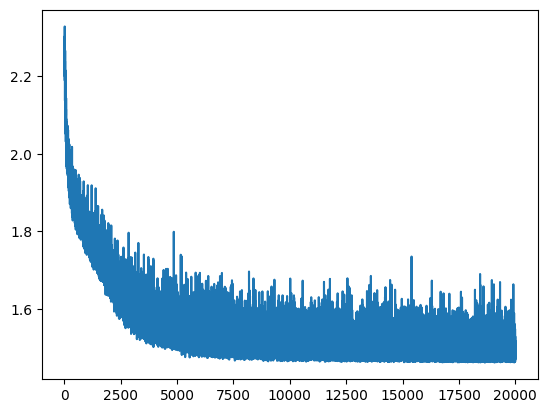

In [69]:
plt.plot(losses);

In [70]:
@torch.no_grad()
def split_loss(split: str):
    x,y = {
        'train': (Xtr, ytr),
        'val': (Xval, yval),
    }[split]
    logits = model(x.float())
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [71]:
with torch.inference_mode():
    split_loss('train')
    split_loss('val')

train 1.4821583032608032
val 1.4843127727508545


In [72]:
# test accuracy
model.eval()
with torch.inference_mode():
    def acc_fn(ytrue, ypred):
        correct = torch.eq(ytrue, ypred).sum().item()
        acc = (correct/len(ypred))*100
        return acc
    logits = model(Xval)
    acc = acc_fn(ypred=logits.argmax(dim=1), ytrue=yval)
    print(f'accuracy: {acc:.2f}%')

accuracy: 97.41%
